In [3]:
# importing libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from math import sqrt


In [4]:
#Load the CSV 
df = pd.read_csv("C:/bikes_data.csv")

In [5]:
df

,bike_name,model price,city,kms_driven,owner,age,bike_model,cc
0,Bajaj Pulsar 180cc,13000,Mansa,28881,First Owner,13,Bajaj Pulsar,180cc
1,Bajaj Pulsar 180cc,15000,Rajkot,28000,First Owner,12,Bajaj Pulsar,180cc
2,Bajaj Pulsar 180cc,15000,Rajkot,28000,First Owner,12,Bajaj Pulsar,180cc
3,Bajaj Pulsar 180cc,16000,Ludhiana,36500,First Owner,13,Bajaj Pulsar,180cc
4,Bajaj Pulsar 180cc,18000,Kolkata,39303,First Owner,13,Bajaj Pulsar,180cc
...,...,...,...,...,...,...,...,...
32643,Yamaha YZF-R3 320cc,250000,Bangalore,45000,First Owner,5,Yamaha YZF-R,3 320cc
32644,Yamaha YZF-R3 320cc,254581,Gorakhpur,19100,First Owner,4,Yamaha YZF-R,3 320cc
32645,Yamaha YZF-R3 320cc,308000,Delhi,16000,First Owner,3,Yamaha YZF-R,3 320cc
32646,Yamaha YZF-R3 320cc ABS,314100,Hyderabad,13500,First Owner,3,Yamaha YZF-R,3 320cc ABS


In [6]:
# Attempt to detect a date column
date_col = None
for col in df.columns:
    try:
        parsed = pd.to_datetime(df[col], errors='coerce')
        if parsed.notna().sum() > max(10, len(df)*0.05):  # at least some parseable dates
            date_col = col
            break
    except Exception:
        continue

if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.sort_values(date_col).reset_index(drop=True)
    df.index = df[date_col]
    print(f"Using detected date column: {date_col}")
else:
    print("No date column auto-detected; using integer index.")


Using detected date column: model price


In [7]:
# Detect target column: prefer 'model price'
target = None
candidates = [c for c in df.columns if df[c].dtype in [np.float64, np.int64] or pd.api.types.is_numeric_dtype(df[c])]
if 'model price' in df.columns:
    target = 'model price'
else:
    # try columns containing 'price'
    price_cols = [c for c in df.columns if 'model price' in c.lower()]
    if price_cols:
        target = price_cols[0]
    elif len(candidates) > 0:
        target = candidates[0]
        
if target is None:
    raise ValueError("No numeric target column found. Please ensure a price/numeric column exists.")

print("Using target column:", target)

Using target column: model price


In [8]:
# choose target column manually
target = 'model price'   # change if needed

# move target to first column
df = df[[target] + [c for c in df.columns if c != target]].copy()

# convert price column to numeric
df[target] = df[target].astype(str).str.replace(r'[^0-9\.]', '', regex=True)
df[target] = pd.to_numeric(df[target], errors='coerce')

# drop missing prices
df = df.dropna(subset=[target])


y = df[target].astype(float)


In [9]:
# Train/test split: time series split 80/20
n = len(y)
train_size = int(n * 0.8)
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")


Train size: 26118, Test size: 6530


In [10]:
# Train/test split: time series split 80/20
n = len(y)
train_size = int(n * 0.8)
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")


Train size: 26118, Test size: 6530


In [20]:
# SARIMAX
sarima_model = SARIMAX(y, order=(1,0,1))
sarima_fit = sarima_model.fit(disp=False)
sarima_preds = sarima_fit.predict(start=int(len(y)*0.8), end=len(y)-1)

y_test = y[int(len(y)*0.8):]
sarima_rmse = np.sqrt(mean_squared_error(y_test, sarima_preds))
sarima_mae = mean_absolute_error(y_test, sarima_preds)
sarima_r2 = r2_score(y_test, sarima_preds)
sarima_mape = np.mean(np.abs((y_test - sarima_preds) / y_test)) * 100


C:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
# Model 2: RandomForest with lag features
print("\nPreparing lag features for RandomForest...")
df_feat = pd.DataFrame({target: y})


Preparing lag features for RandomForest...


In [13]:
# create lags and rolling means
for lag in [1,2,3,6,12]:
    df_feat[f'lag_{lag}'] = df_feat[target].shift(lag)
df_feat['roll_3'] = df_feat[target].shift(1).rolling(window=3, min_periods=1).mean()
df_feat['roll_6'] = df_feat[target].shift(1).rolling(window=6, min_periods=1).mean()
df_feat = df_feat.dropna()

# align train/test indexes for features
train_idx = df_feat.index[:train_size]
test_idx = df_feat.index[train_size:]
X_train = df_feat.drop(columns=[target]).loc[train_idx]
y_train_rf = df_feat[target].loc[train_idx]
X_test = df_feat.drop(columns=[target]).loc[test_idx]
y_test_rf = df_feat[target].loc[test_idx]

print("RF train shape:", X_train.shape, "RF test shape:", X_test.shape)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train_rf)
rf_pred = rf.predict(X_test)
rf_rmse = sqrt(mean_squared_error(y_test_rf, rf_pred))
rf_mae = mean_absolute_error(y_test_rf, rf_pred)
rf_r2 = r2_score(y_test_rf, rf_pred)
rf_mape = (np.mean(np.abs((y_test_rf - rf_pred) / y_test_rf)) * 100)


RF train shape: (22992896, 7) RF test shape: (2504008, 7)


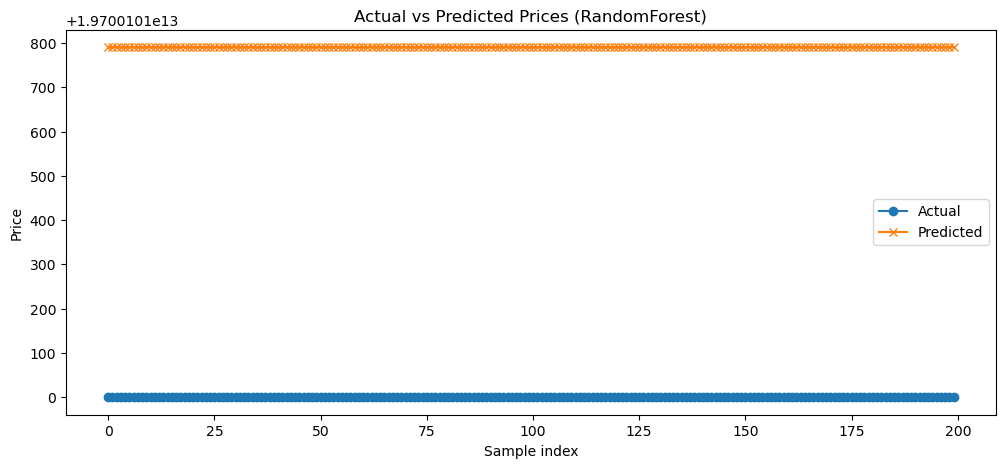

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label='Actual', marker='o')
plt.plot(rf_pred[:200], label='Predicted', marker='x')
plt.title("Actual vs Predicted Prices (RandomForest)")
plt.xlabel("Sample index")
plt.ylabel("Price")
plt.legend()
plt.show()